# SELF DRIVING CAR

This code is to train car to drive itself.

The simulation is performed on a steering wheel (can be tested in the model script

## Preprocessing

### Install Libraries

In [1]:
!pip install scipy==1.2.2

     |████████████████████████████████| 24.8 MB 36 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
from __future__ import division

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import random
import cv2
import math
import numpy as np
import scipy
import scipy.misc
from scipy import pi
from subprocess import call
from datetime import datetime
from itertools import islice
import matplotlib.pyplot as plt 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# import os
# os.chdir("/content/drive/MyDrive/Dataset")

### Unzipping Dataset

In [4]:
!unzip -u "/content/drive/MyDrive/Dataset/driving_dataset.zip" -d "/content/drive/MyDrive/Dataset/dataset"

Archive:  /content/drive/MyDrive/Dataset/driving_dataset.zip
  inflating: /content/drive/MyDrive/Dataset/dataset/driving_dataset/.DS_Store  


### Loading Dataset and splitting to train and testing set

In [5]:
image_data = []
angle_data = []

# Get number of images
num_images = 0

# Number of images for training
num_train_images = 0

# Number of images for testing
num_test_images = 0

def load_dataset():
    # Read data.txt
    with open("/content/drive/MyDrive/Dataset/dataset/driving_dataset/data.txt") as fp:
        for line in fp:
            image_data.append("/content/drive/MyDrive/Dataset/dataset/driving_dataset/" + line.split()[0])

            # the paper by Nvidia uses the inverse of the turning radius,
            # but steering wheel angle is proportional to the inverse of turning radius
            # so the steering wheel angle in radians is used as the output       
            angle_data.append(float(line.split()[1]) * scipy.pi / 180)

def split_dataset(train_split,test_split):
    images_to_train = image_data[:int(len(image_data) * train_split)]    
    angles_to_train = angle_data[:int(len(image_data) * train_split)]

    images_to_test = image_data[-int(len(image_data) * test_split):]
    angles_to_test = angle_data[-int(len(image_data) * test_split):]
    
    return images_to_train,angles_to_train,images_to_test,angles_to_test   
    

In [6]:
# Load dataset
load_dataset()

# Split dataset
images_to_train,angles_to_train,images_to_test,angles_to_test = split_dataset(0.8,0.2)

num_images = len(image_data)
print("Total number of images: ",num_images)

num_train_images = len(images_to_train)
print("Total number of images for training: ",num_train_images)

num_test_images = len(images_to_test)
print("Total number of images for testing: ",num_test_images)

Total number of images:  45406
Total number of images for training:  36324
Total number of images for testing:  9081


### Simple EDA on Dataset

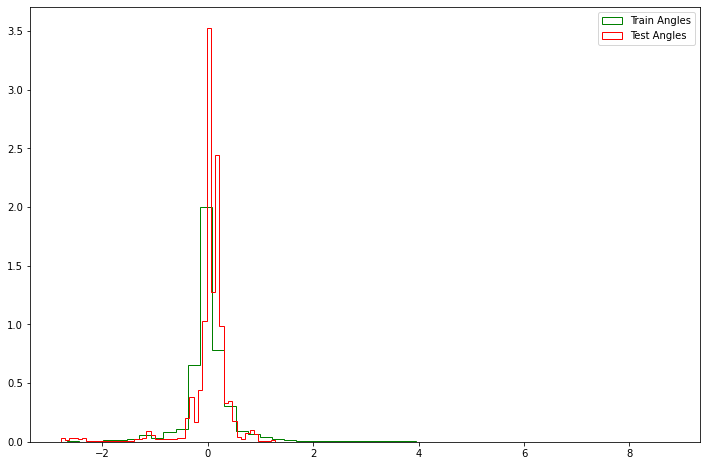

In [7]:
# PDF of train and test angle values. 
plt.figure(figsize=(12,8))
plt.hist(angles_to_train, bins=50, density=1, color='green', histtype ='step',label="Train Angles")
plt.hist(angles_to_test, bins=50, density=1, color='red', histtype ='step',label="Test Angles")
plt.legend()
plt.show()

## Modelling

### Model 1: Base line Model: y_test_pred = mean(y_train_i)

In [8]:
#Model 1: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_angle = np.mean(angles_to_train)

print('Test_MSE(MEAN):%f' % np.mean(np.square(angles_to_test - train_mean_angle)))

Test_MSE(MEAN):0.191142


### Create End to End Model
Credits End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]


Model - Configuration Used:

- Train/Test Split: 80:20

- Dropout : 0.80

- AdamOptimezer Value: 1e-4

- Activation Function: atan

In [9]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

In [10]:
true_image = tf.placeholder(tf.float32, shape=[None, 66, 200, 3],name="true_image")
true_angle = tf.placeholder(tf.float32, shape=[None, 1],name="true_angle")

x_image = true_image

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32,name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

# atan activation function with scaling
predicted_angle = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2)
predicted_angle = tf.identity(predicted_angle,name="predicted_angle")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Model Training

### Model with 'atan' activation function

In [12]:
#points to the end of the last batch
train_batch_pointer = 0
test_batch_pointer = 0

# Utility Functions
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(images_to_train[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([angles_to_train[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadTestBatch(batch_size): 
    global test_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(images_to_test[(test_batch_pointer + i) % num_test_images])[-150:], [66, 200]) / 255.0)
        y_out.append([angles_to_test[(test_batch_pointer + i) % num_test_images]])
    test_batch_pointer += batch_size
    return x_out, y_out

In [13]:
LOGDIR = '/content/drive/MyDrive/Dataset/dataset/models/atan/'

# Lets start the tensorflow session
sess = tf.InteractiveSession()

In [14]:
start = datetime.now()

print("Let the model learn itself...")
print()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(true_angle, predicted_angle))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)

# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver()

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 500

# train over the dataset about 30 times
previous_i = 0
previous_loss = 0
for epoch in range(epochs):
    for i in range(int(num_images/batch_size)):
        print(i)
        xs, ys = LoadTrainBatch(batch_size)
        print(i)
        train_step.run(feed_dict={true_image: xs, true_angle: ys, keep_prob: 0.80})
        if i % 10 == 0:            
            xs, ys = LoadTestBatch(batch_size)
            loss_value = loss.eval(feed_dict={true_image:xs, true_angle: ys, keep_prob: 1.0})
            previous_loss = loss_value
            previous_i = i
            # print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

        # write logs at every iteration
        xx = 1.0
        # print(xs,ys,xx)
        summary = merged_summary_op.eval(feed_dict={true_image:xs, true_angle: ys, keep_prob: xx})
        summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)            
            checkpoint_path = os.path.join(LOGDIR, "model_atan.ckpt")
            filename = saver.save(sess, checkpoint_path)    
    print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + previous_i, previous_loss)) 
    print("Model saved in file: %s" % filename)
    print()

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

print("\nTime taken to train the model: ",datetime.now() - start)

Streaming output truncated to the last 5000 lines.
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
Epoch: 2, Step: 1080, Loss: 8.43854
Model saved in file: /content/drive/MyDrive/Dataset/dataset/models/atan/model_atan.ckpt

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
Epoch: 3, Step: 1580, Loss: 7.42622
Model saved in file: /content/drive/MyDrive/Dataset/dataset/models/atan/model_atan.ckpt

0
0
1
1
2
2
3
3
4
4
5
5
6


## Future Work (Model 2 can be used for further testing, using linear activation method)
Due to limited resources, I left this as an option for the future once I have enough resources to train a model)

In [11]:
true_image_ln = tf.placeholder(tf.float32, shape=[None, 66, 200, 3],name="true_image_ln")
true_angle_ln = tf.placeholder(tf.float32, shape=[None, 1],name="true_angle_ln")

x_image_ln = true_image_ln

#first convolutional layer
W_conv1_ln = weight_variable([5, 5, 3, 24])
b_conv1_ln = bias_variable([24])

h_conv1_ln = tf.nn.relu(conv2d(x_image_ln, W_conv1_ln, 2) + b_conv1_ln)

#second convolutional layer
W_conv2_ln = weight_variable([5, 5, 24, 36])
b_conv2_ln = bias_variable([36])

h_conv2_ln = tf.nn.relu(conv2d(h_conv1_ln, W_conv2_ln, 2) + b_conv2_ln)

#third convolutional layer
W_conv3_ln = weight_variable([5, 5, 36, 48])
b_conv3_ln = bias_variable([48])

h_conv3_ln = tf.nn.relu(conv2d(h_conv2_ln, W_conv3_ln, 2) + b_conv3_ln)

#fourth convolutional layer
W_conv4_ln = weight_variable([3, 3, 48, 64])
b_conv4_ln = bias_variable([64])

h_conv4_ln = tf.nn.relu(conv2d(h_conv3_ln, W_conv4_ln, 1) + b_conv4_ln)

#fifth convolutional layer
W_conv5_ln = weight_variable([3, 3, 64, 64])
b_conv5_ln = bias_variable([64])

h_conv5_ln = tf.nn.relu(conv2d(h_conv4_ln, W_conv5_ln, 1) + b_conv5_ln)

#FCL 1
W_fc1_ln = weight_variable([1152, 1164])
b_fc1_ln = bias_variable([1164])

h_conv5_flat_ln = tf.reshape(h_conv5_ln, [-1, 1152])
h_fc1_ln = tf.nn.relu(tf.matmul(h_conv5_flat_ln, W_fc1_ln) + b_fc1_ln)

keep_prob_ln = tf.placeholder(tf.float32,name="keep_prob_ln")
h_fc1_drop_ln = tf.nn.dropout(h_fc1_ln, keep_prob_ln)

#FCL 2
W_fc2_ln = weight_variable([1164, 100])
b_fc2_ln = bias_variable([100])

h_fc2_ln = tf.nn.relu(tf.matmul(h_fc1_drop_ln, W_fc2_ln) + b_fc2_ln)

h_fc2_drop_ln = tf.nn.dropout(h_fc2_ln, keep_prob_ln)

#FCL 3
W_fc3_ln = weight_variable([100, 50])
b_fc3_ln = bias_variable([50])

h_fc3_ln = tf.nn.relu(tf.matmul(h_fc2_drop_ln, W_fc3_ln) + b_fc3_ln)

h_fc3_drop_ln = tf.nn.dropout(h_fc3_ln, keep_prob_ln)

#FCL 3
W_fc4_ln = weight_variable([50, 10])
b_fc4_ln = bias_variable([10])

h_fc4_ln = tf.nn.relu(tf.matmul(h_fc3_drop_ln, W_fc4_ln) + b_fc4_ln)

h_fc4_drop_ln = tf.nn.dropout(h_fc4_ln, keep_prob_ln)

#Output
W_fc5_ln = weight_variable([10, 1])
b_fc5_ln = bias_variable([1])

# linear activation function
predicted_angle_ln = tf.matmul(h_fc4_drop_ln, W_fc5_ln) + b_fc5_ln
predicted_angle_ln = tf.identity(predicted_angle_ln,name="predicted_angle_ln")

In [15]:
# Lets close the tensorflow session
sess.close()

In [16]:
# Split dataset
images_to_train,angles_to_train,images_to_test,angles_to_test = split_dataset(0.7,0.3)

num_images = len(image_data)
print("Total number of images: ",num_images)

num_train_images = len(images_to_train)
print("Total number of images for training: ",num_train_images)

num_test_images = len(images_to_test)
print("Total number of images for testing: ",num_test_images)

# Reset the pointers
train_batch_pointer = 0
test_batch_pointer = 0

Total number of images:  45406
Total number of images for training:  31784
Total number of images for testing:  13621


In [17]:
LOGDIR = '/content/drive/MyDrive/Dataset/dataset/models/linear/'

# Lets start the tensorflow session
sess = tf.InteractiveSession()

In [ ]:
start = datetime.now()

print("Let the model learn itself...")
print()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(true_angle_ln, predicted_angle_ln))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)

# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver()

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 1000

# train over the dataset about 30 times
previous_i = 0
previous_loss = 0
for epoch in range(epochs):
    for i in range(int(num_images/batch_size)):        
        xs, ys = LoadTrainBatch(batch_size)
        train_step.run(feed_dict={true_image_ln: xs, true_angle_ln: ys, keep_prob_ln: 0.50})
        print("PASS")
        if i % 10 == 0:            
            xs, ys = LoadTestBatch(batch_size)
            loss_value = loss.eval(feed_dict={true_image_ln:xs, true_angle_ln: ys, keep_prob_ln: 1.0})
            previous_loss = loss_value
            previous_i = i
            # print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

        # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={true_image_ln:xs, true_angle_ln: ys, keep_prob_ln: 1.0})
        summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)            
            checkpoint_path = os.path.join(LOGDIR, "model_linear.ckpt")
            filename = saver.save(sess, checkpoint_path)    
    print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + previous_i, previous_loss)) 
    print("Model saved in file: %s" % filename)
    print()

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

print("\nTime taken to train the model: ",datetime.now() - start)

In [ ]:
# Lets close the tensorflow session
sess.close()